In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, LabelEncoder
from scipy import stats
from itertools import cycle

%matplotlib inline
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


Bad key "text.kerning_factor" on line 4 in
/home/moon23k/anaconda3/envs/Basic_conda_env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data = pd.read_csv('data/winequality-red.csv')
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


### EDA : Exporatory Data Analysis

In [3]:
len(data)

1599

In [4]:
# check missing data

data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

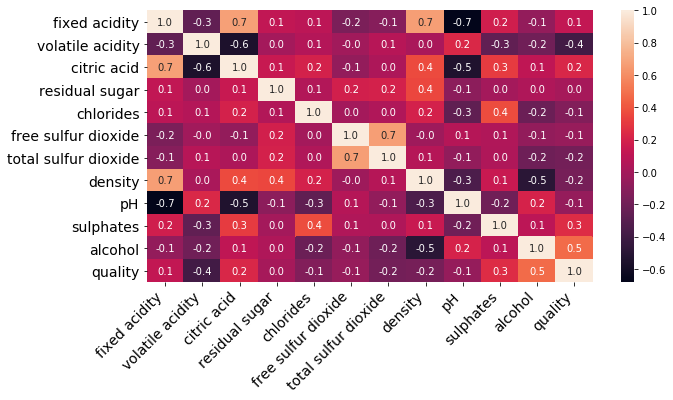

In [5]:
# correlation matrix

plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(data.corr(), annot=True, fmt='.1f')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)

plt.show()

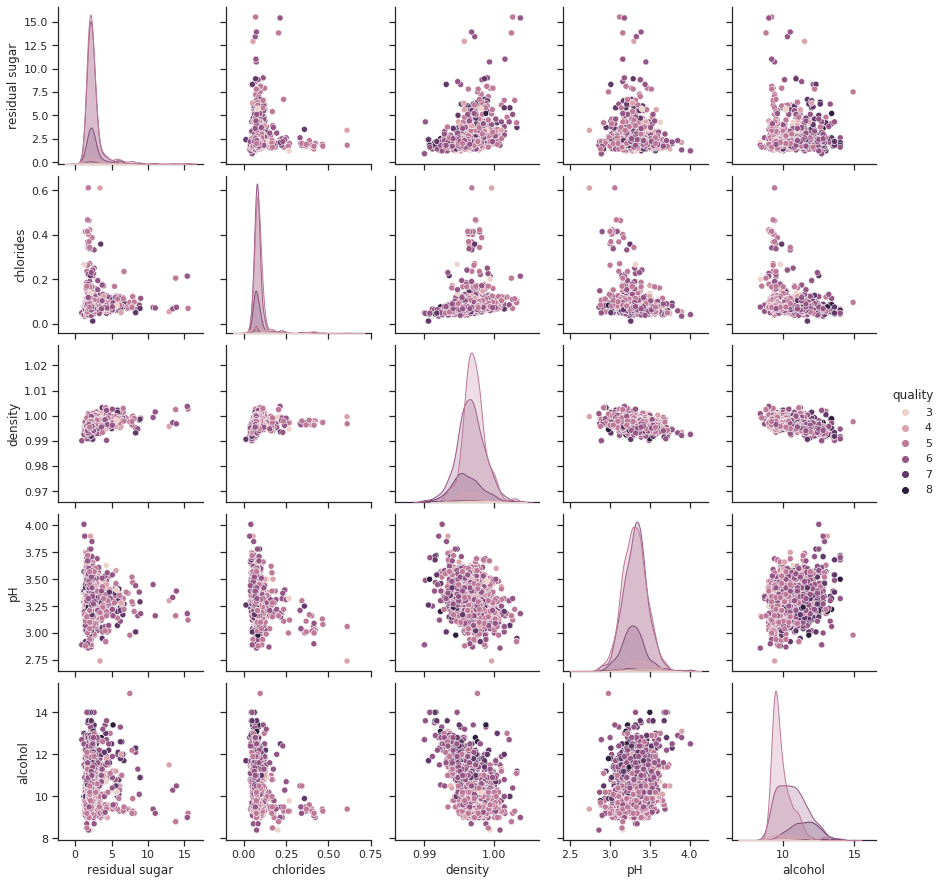

In [6]:
# plot pairwise relationships in data for few features (plot size contraint)

cols_sns = ['residual sugar', 'chlorides', 'density', 'pH', 'alcohol', 'quality']
sns.set(style='ticks')
sns.pairplot(data[cols_sns], hue='quality')

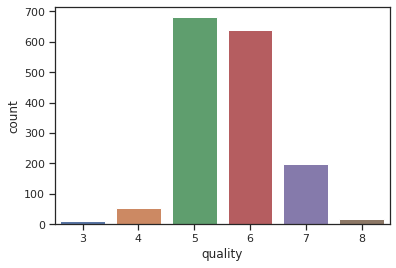

In [7]:
sns.countplot(x='quality', data=data)

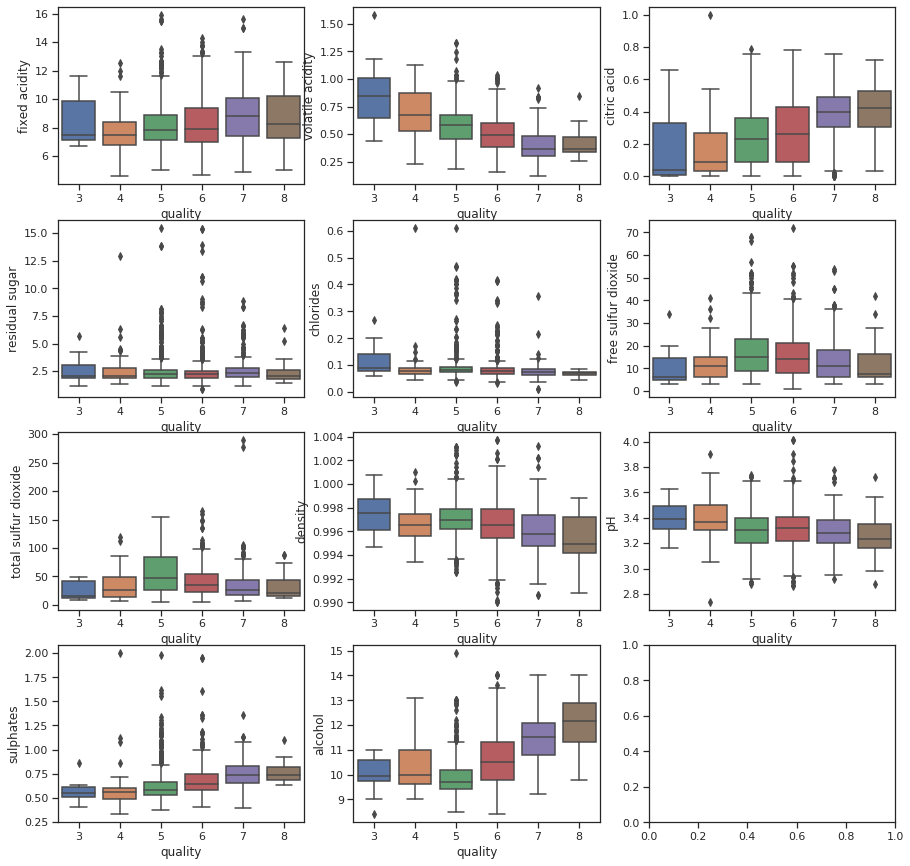

In [8]:
# Features distribution over quality's possible values

fig, ax = plt.subplots(4, 3, figsize=(15, 15))

for var, subplot in zip(data.columns, ax.flatten()):
    if var == 'quality':
        continue
    else:
        sns.boxplot(x=data['quality'], y=data[var], data=data, ax=subplot)

In [9]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### Preparing Data

In [10]:
features, labels = data.loc[:, data.columns != 'quality'], data['quality']

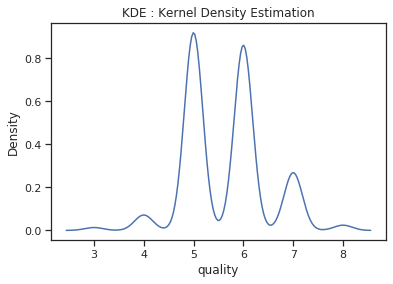

In [11]:
sns.distplot(labels, kde=True, hist=False)
plt.title('KDE : Kernel Density Estimation')
plt.show()

In [12]:
# Scaling Data

scaler = MinMaxScaler()
X = scaler.fit_transform(features)

In [13]:
# classic split the data into train and test sets for unbalanced data is not a good idea
# xtr, xts, ytr, yts = train_test_split(X, labels, test_size=0.3, random_state=42, shuffle=True)

# We'll opt for stratified shuffled split for better class proportions
sss = StratifiedShuffleSplit(test_size=0.3)

for train_index, test_index in sss.split(X, labels):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [14]:
# check if train and test labels have the same set of possible values

y_train.unique(), y_test.unique()

(array([5, 6, 7, 8, 4, 3]), array([5, 6, 4, 7, 8, 3]))

### Logistic Regression

In [15]:
lr = LogisticRegression(multi_class='ovr', class_weight='balanced', random_state=42)

In [16]:
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=42)

In [17]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.08      0.33      0.13         3
           4       0.15      0.50      0.23        16
           5       0.65      0.69      0.67       204
           6       0.61      0.28      0.38       192
           7       0.36      0.58      0.45        60
           8       0.06      0.20      0.09         5

    accuracy                           0.50       480
   macro avg       0.32      0.43      0.33       480
weighted avg       0.57      0.50      0.50       480



In [18]:
classes_q = sorted(data.quality.unique())
classes_q

[3, 4, 5, 6, 7, 8]

In [19]:
# For ROC curves we have to binarize labels

y_test_bin = label_binarize(y_test, classes=classes_q)
y_pred_bin = label_binarize(y_pred, classes=classes_q)

# Compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes_q)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

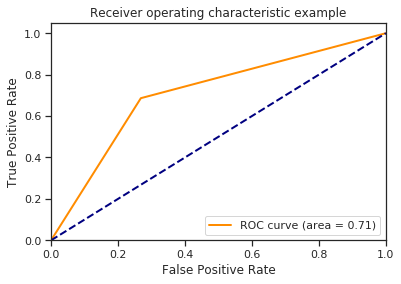

In [20]:
#ROC for a specific class

lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

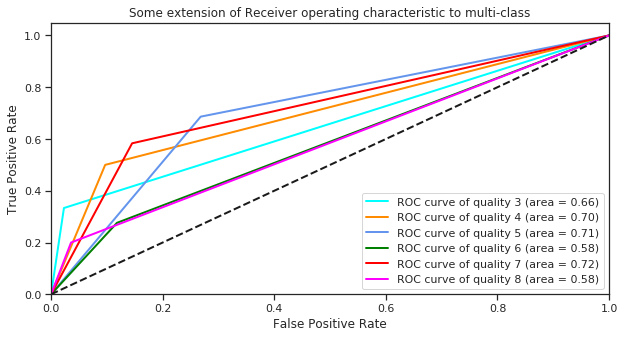

In [21]:
#ROC for multiclass #sklearn doc

# First aggregate all false positive rates

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes_q))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes_q)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(classes_q)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,5))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'magenta'])
for i, color in zip(range(len(classes_q)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of quality {0} (area = {1:0.2f})'
             ''.format(classes_q[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [22]:
### Binary Classification

In [23]:
# Initial Dataset

data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [24]:
# Transform labels into binary ones : 'bad' and 'good'

bins = (2, 6.5, 8)
quality_names = ['bad', 'good']
data['quality'] = pd.cut(data.quality, bins=bins, labels=quality_names)
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,bad
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,bad
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,bad
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,good
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,good
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,bad


In [25]:
data.quality.value_counts()

bad     1382
good     217
Name: quality, dtype: int64

### EDA : Binary Classification Task

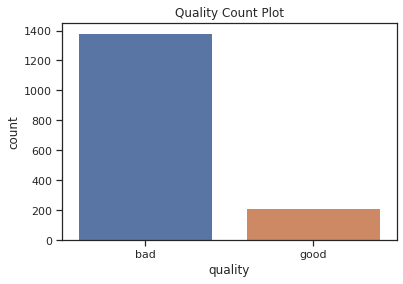

In [26]:
sns.countplot(data=data, x='quality')
plt.title('Quality Count Plot')
plt.show()

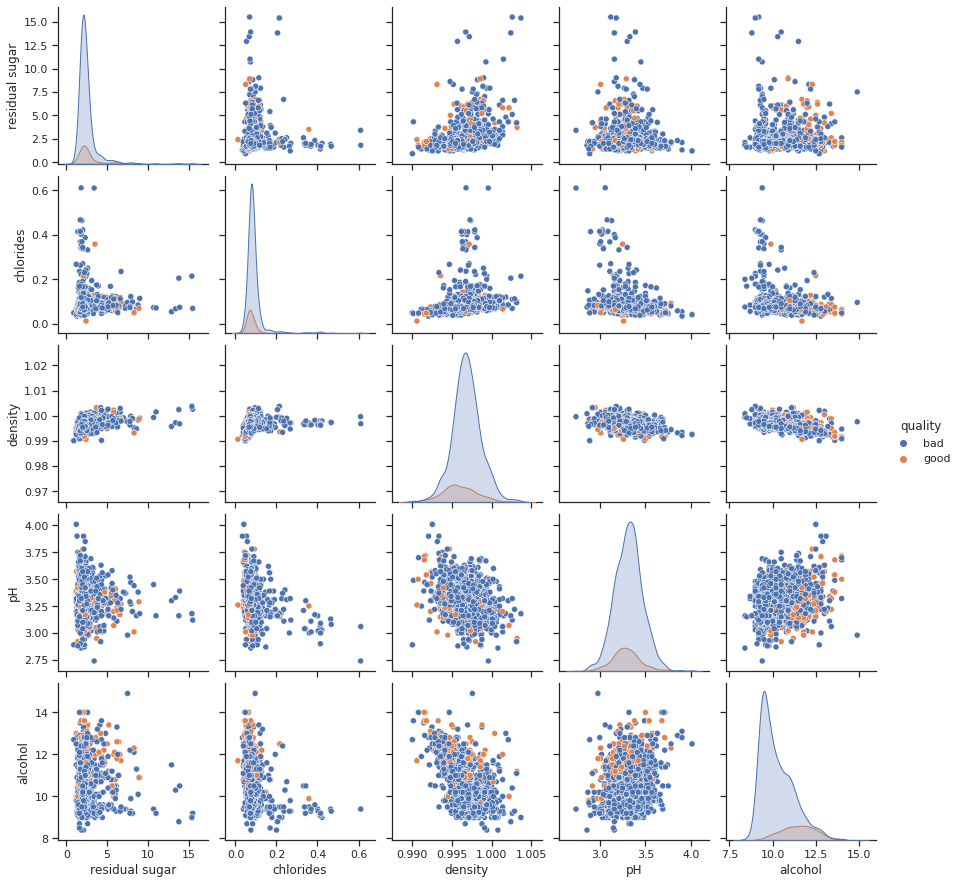

In [27]:
# Plot pairwise relationships in data for few features


cols_sns = ['residual sugar', 'chlorides', 'density', 'pH', 'alcohol', 'quality']
sns.set(style='ticks')
sns.pairplot(data[cols_sns], hue='quality')

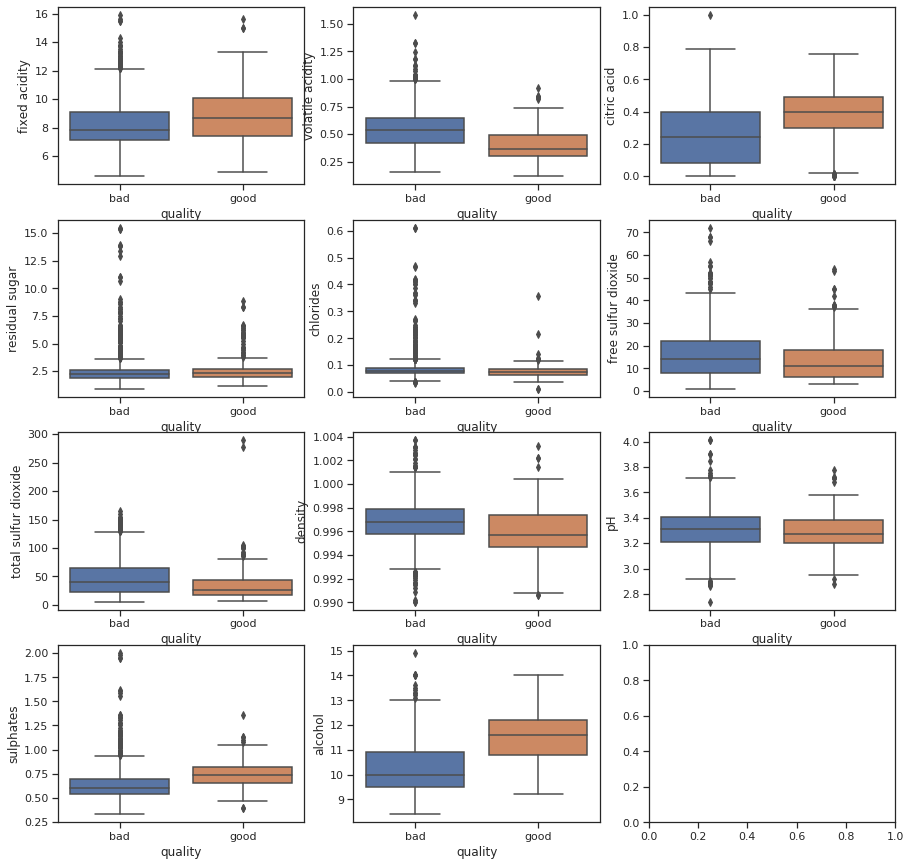

In [28]:
# Features distribution over quality's possible values
fig, ax = plt.subplots(4, 3, figsize=(15, 15))
for var, subplot in zip(data.columns, ax.flatten()):
    if var == "quality":
        continue
    else:
        sns.boxplot(x=data['quality'], y=data[var], data=data, ax=subplot)

In [29]:
# Encoding labels

label_encoder = LabelEncoder()
data['quality'] = label_encoder.fit_transform(data['quality'])
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,0


In [30]:
#Prepare data
X, y = data.loc[:, data.columns != 'quality'], data['quality']
new_scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#We'll opt for stratified shuffled split again for better class proportions
new_sss = StratifiedShuffleSplit(test_size=0.3)
for train_index, test_index in new_sss.split(X, labels):
    new_X_train, new_X_test = X[train_index], X[test_index]
    new_y_train, new_y_test = y[train_index], y[test_index]

### Logistic Regression

In [31]:
log_reg = LogisticRegression(random_state=42)

log_reg.fit(new_X_train, new_y_train)

LogisticRegression(random_state=42)

In [33]:
logreg_y_pred = log_reg.predict(new_X_test)

In [34]:
print(f'Precision Score: {precision_score(new_y_test, logreg_y_pred)}')
print(f'Recall Score: {recall_score(new_y_test, logreg_y_pred)}')
print(f'F1-Score: {f1_score(new_y_test, logreg_y_pred)}') 

Precision Score: 0.6111111111111112
Recall Score: 0.16923076923076924
F1-Score: 0.2650602409638554


In [35]:
#Cross Validation for Logistic Regression

lg = LogisticRegression()
cv_lg_result = cross_val_score(lg, X, y, cv=5, scoring='f1_macro')

In [36]:
print(f'Mean F1-Score of Cross Validation {np.mean(cv_lg_result)}')

Mean F1-Score of Cross Validation 0.5812076513431899


In [37]:
#Grid Search 
grid ={"C": [0.001,0.01,0.1,1,10,100]}
lg_ = LogisticRegression()
lg_cv = GridSearchCV(lg_, grid, cv=3)
lg_cv.fit(new_X_train, new_y_train)

#hyperparameters
print(f"Tuned hyperparameters: {lg_cv.best_params_}")
print(f"Best score: {lg_cv.best_score_}")

Tuned hyperparameters: {'C': 10}
Best score: 0.8766756032171582


In [38]:
best_logreg = lg_cv.best_estimator_
best_logreg

LogisticRegression(C=10)

In [39]:
y_gs_pred = best_logreg.predict(new_X_test)

print("With Grid Search...")
print(f'Precision Score: {precision_score(new_y_test, y_gs_pred)}')
print(f'Recall Score: {recall_score(new_y_test, y_gs_pred)}')
print(f'F1-Score: {f1_score(new_y_test, y_gs_pred)}') 

With Grid Search...
Precision Score: 0.6333333333333333
Recall Score: 0.2923076923076923
F1-Score: 0.39999999999999997


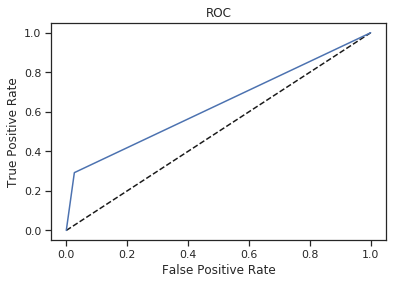

In [40]:
#ROC

fpr, tpr, thresholds = roc_curve(new_y_test, y_gs_pred)
plt.plot([0,1], [0,1], '--k')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

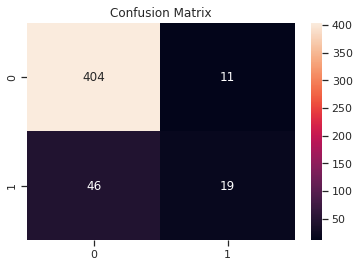

In [41]:
#Confusion Matrix

cm = confusion_matrix(new_y_test, y_gs_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

In [42]:
rf = RandomForestClassifier(random_state=42)
rf.fit(new_X_train, new_y_train)

RandomForestClassifier(random_state=42)

In [43]:
y_rf_pred = rf.predict(new_X_test)

In [44]:
print('Random Forest Performance...')
print(f'Precision Score: {precision_score(new_y_test, y_rf_pred)}')
print(f'Recall Score: {recall_score(new_y_test, y_rf_pred)}')
print(f'F1-Score: {f1_score(new_y_test, y_rf_pred)}') 

Random Forest Performance...
Precision Score: 0.8108108108108109
Recall Score: 0.46153846153846156
F1-Score: 0.5882352941176471


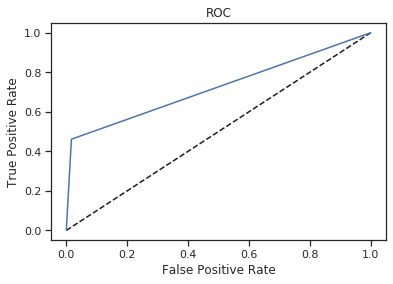

In [45]:
#ROC

fpr_rf, tpr_rf, thresholds_rf = roc_curve(new_y_test, y_rf_pred)
plt.plot([0,1], [0,1], '--k')
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

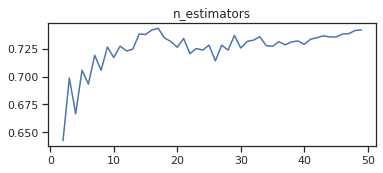

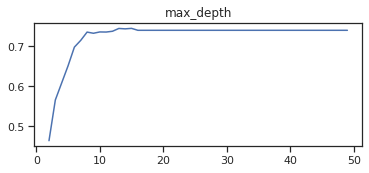

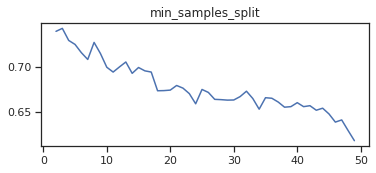

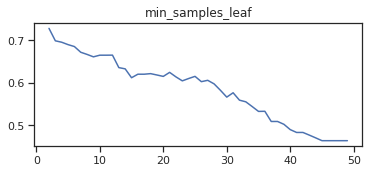

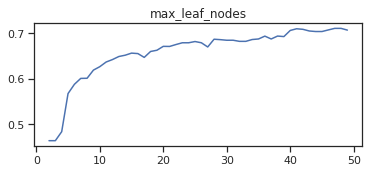

In [46]:
rf_param_grid = {"n_estimators": np.arange(2,50),
                "max_depth": np.arange(2,50),
                "min_samples_split": np.arange(2,50),
                "min_samples_leaf":np.arange(2,50),
                "max_leaf_nodes": np.arange(2,50)}


i=1
for param, range_param in rf_param_grid.items():
        rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid={param:range_param},
                              scoring='f1_macro')
        rf_grid.fit(new_X_train, new_y_train)
        df = pd.DataFrame(rf_grid.cv_results_)
        plt.figure(figsize=(20,5))
        plt.subplot(2,3,i)
        plt.plot(range_param, df.mean_test_score.values)
        plt.title(param)
        i += 1

In [47]:
#Based on the plots above we can test the following model

rf_test = RandomForestClassifier(n_estimators=28,
                                max_depth=14,
                                random_state=42)
rf_test.fit(new_X_train, new_y_train)
yy = rf_test.predict(new_X_test)
f1_score(new_y_test, yy)

0.6019417475728156